In [1]:
import warnings
warnings.filterwarnings('ignore')

# Going to cover
0. **Architecture of a classification neural network** 
1. **Getting binary classification data ready**	
2. **Building a PyTorch classification model**	
3. **Fitting the model to data (training**
4. **Making predictions and evaluating a model (inference)**
5. **Improving a model (from a model perspective)**
6. **Non-linearity**
7. **Replicating non-linear functions**
8. **Putting it all together with multi-class classification**

# 0. Architecture of a classification neural network
![title](media/architect.png)

# 1. Getting binary classification data ready

In [10]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000
# create circle
X, y = make_circles(n_samples, noise=0.03, random_state=42)
X.shape, y.shape

((1000, 2), (1000,))

In [11]:
# make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:,1], "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [12]:
# Check diffrent labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

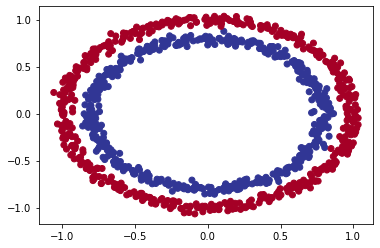

In [18]:
# Let's plot them
import matplotlib.pyplot as plt
plt.scatter(x=circles.X1, 
            y=circles.X2, 
            c=circles.label, 
            cmap=plt.cm.RdYlBu);

## Turn data into tensors and create train and test splits

In [21]:
import torch
X = torch.tensor(circles[['X1', 'X2']].values).type(torch.float)
y = torch.tensor(circles['label'].values).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [23]:
X.shape, y.shape

(torch.Size([1000, 2]), torch.Size([1000]))

In [24]:
# Split data into train test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2,
                                                   random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

# 2. Building a model

In [25]:
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Create Model

In [29]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) 
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

**Similar can be done using nn.sequential**

In [30]:
# Replicate CircleModelV0 with nn.Sequential
model_test = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_test

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

**Make prediction using untrained model**

In [31]:
untrained_preds = model_0(X_test.to(device))
untrained_preds[:5], y_test[:5]

(tensor([[0.1831],
         [0.2477],
         [0.0407],
         [0.2233],
         [0.0838]], grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1.]))

## Setup loss function and optimizer

In [32]:
# BCEWithLogitsLoss = sigmoid built-in (Binary cross entropy with sigmoid function)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


In [33]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc


# 3. Train model

## Prediction probability and labels output

In [34]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.1831],
        [0.2477],
        [0.0407],
        [0.2233],
        [0.0838]], grad_fn=<SliceBackward0>)

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.

In [35]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5456],
        [0.5616],
        [0.5102],
        [0.5556],
        [0.5209]], grad_fn=<SigmoidBackward0>)

These values can be viewed as a decision boundary.
The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:

* If y_pred_probs >= 0.5, y=1 (class 1)
* If y_pred_probs < 0.5, y=0 (class 0)

To turn our prediction probabilities in prediction labels, we can round the outputs of the sigmoid activation function.

In [37]:
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
y_pred_labels[:5]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SliceBackward0>)

In [38]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## Building a training and testing loop
Let's start by training for 100 epochs and outputing the model's progress every 10 epochs.

In [45]:
torch.manual_seed(42)
epochs = 100
# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building train and evaluation loop
for epoch in range(epochs):
    ## Training
    model_0.train()
    
    # forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ## Testing
    model_0.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    if epoch%10==0:
        print(f"""Epoch: {epoch} 
                  Loss: {loss:.5f},
                  Accuracy: {acc:.2f}% 
                  Test Loss {test_loss: .5f},
                  Test Accuracy: {test_acc:.2f}%""")
    

Epoch: 0 
                  Loss: 0.69312,
                  Accuracy: 51.50% 
                  Test Loss  0.69642,
                  Test Accuracy: 45.50%
Epoch: 10 
                  Loss: 0.69312,
                  Accuracy: 51.62% 
                  Test Loss  0.69636,
                  Test Accuracy: 45.50%
Epoch: 20 
                  Loss: 0.69311,
                  Accuracy: 51.50% 
                  Test Loss  0.69631,
                  Test Accuracy: 45.50%
Epoch: 30 
                  Loss: 0.69310,
                  Accuracy: 51.50% 
                  Test Loss  0.69626,
                  Test Accuracy: 45.50%
Epoch: 40 
                  Loss: 0.69309,
                  Accuracy: 51.50% 
                  Test Loss  0.69621,
                  Test Accuracy: 45.50%
Epoch: 50 
                  Loss: 0.69309,
                  Accuracy: 51.38% 
                  Test Loss  0.69617,
                  Test Accuracy: 45.50%
Epoch: 60 
                  Loss: 0.69308,
         

## Plot decision boundaries

In [47]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


helper_functions.py already exists, skipping download


In [56]:
from helper_functions import plot_predictions, plot_decision_boundary

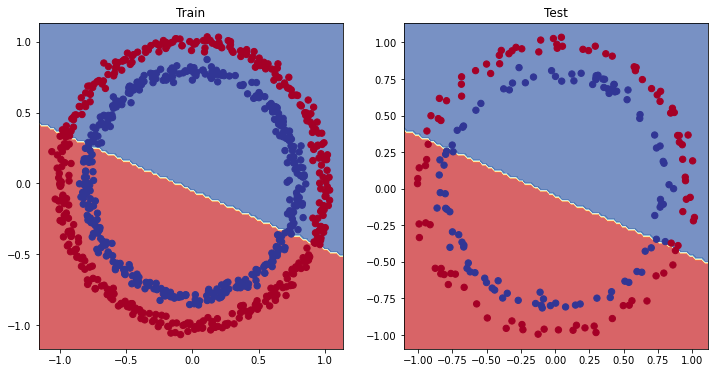

In [57]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 4. Improving a model

![title](media/improve_model.png)

## Adding more layer

In [61]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [62]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [63]:
torch.manual_seed(42)
epochs = 1000
# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building train and evaluation loop
for epoch in range(epochs):
    ## Training
    model_1.train()
    
    # forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ## Testing
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    if epoch%10==0:
        print(f"""Epoch: {epoch} 
                  Loss: {loss:.5f},
                  Accuracy: {acc:.2f}% 
                  Test Loss {test_loss: .5f},
                  Test Accuracy: {test_acc:.2f}%""")
    

Epoch: 0 
                  Loss: 0.69396,
                  Accuracy: 50.88% 
                  Test Loss  0.69261,
                  Test Accuracy: 51.00%
Epoch: 10 
                  Loss: 0.69369,
                  Accuracy: 50.25% 
                  Test Loss  0.69270,
                  Test Accuracy: 50.00%
Epoch: 20 
                  Loss: 0.69351,
                  Accuracy: 50.12% 
                  Test Loss  0.69283,
                  Test Accuracy: 49.50%
Epoch: 30 
                  Loss: 0.69339,
                  Accuracy: 50.50% 
                  Test Loss  0.69297,
                  Test Accuracy: 48.00%
Epoch: 40 
                  Loss: 0.69329,
                  Accuracy: 50.38% 
                  Test Loss  0.69310,
                  Test Accuracy: 49.00%
Epoch: 50 
                  Loss: 0.69322,
                  Accuracy: 49.88% 
                  Test Loss  0.69324,
                  Test Accuracy: 50.00%
Epoch: 60 
                  Loss: 0.69317,
         

Epoch: 680 
                  Loss: 0.69298,
                  Accuracy: 51.00% 
                  Test Loss  0.69468,
                  Test Accuracy: 46.00%
Epoch: 690 
                  Loss: 0.69298,
                  Accuracy: 51.00% 
                  Test Loss  0.69468,
                  Test Accuracy: 46.00%
Epoch: 700 
                  Loss: 0.69298,
                  Accuracy: 51.00% 
                  Test Loss  0.69468,
                  Test Accuracy: 46.00%
Epoch: 710 
                  Loss: 0.69298,
                  Accuracy: 51.00% 
                  Test Loss  0.69468,
                  Test Accuracy: 46.00%
Epoch: 720 
                  Loss: 0.69298,
                  Accuracy: 51.00% 
                  Test Loss  0.69468,
                  Test Accuracy: 46.00%
Epoch: 730 
                  Loss: 0.69298,
                  Accuracy: 51.00% 
                  Test Loss  0.69468,
                  Test Accuracy: 46.00%
Epoch: 740 
                  Loss: 0.69298,
 

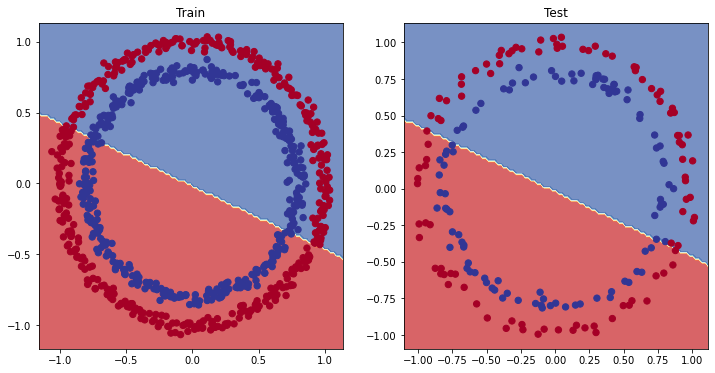

In [64]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## Using lon-linear function ReLu

In [65]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [66]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)
epochs = 1000
# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building train and evaluation loop
for epoch in range(epochs):
    ## Training
    model_3.train()
    
    # forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    ## Testing
    model_1.eval()
    with torch.inference_mode():
        # forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    if epoch%10==0:
        print(f"""Epoch: {epoch} 
                  Loss: {loss:.5f},
                  Accuracy: {acc:.2f}% 
                  Test Loss {test_loss: .5f},
                  Test Accuracy: {test_acc:.2f}%""")
    

In [68]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

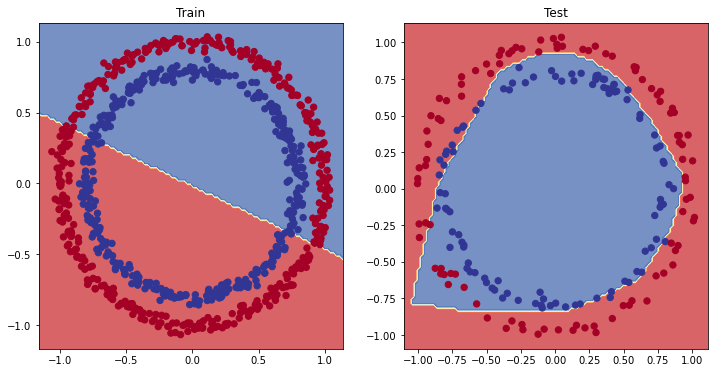

In [69]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# 5. Putting things together by building a multi-class PyTorch model

## Creating classification data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


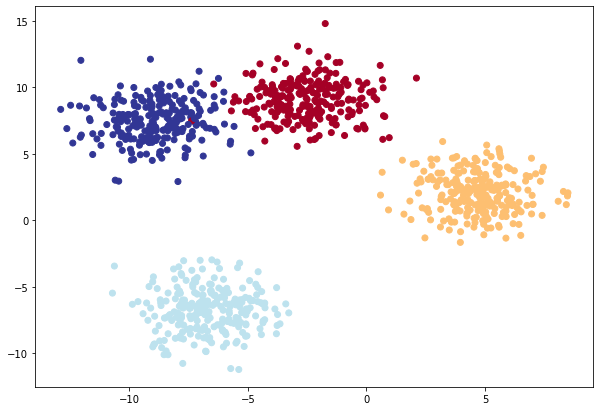

In [70]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## Building model

In [71]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [75]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)
        
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4
        

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Creating a loss function and optimizer 

In [76]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1)

In [77]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.8696, -0.7083, -0.3200,  0.5513],
        [-0.1989, -2.0320,  0.4267, -1.2864],
        [-0.9819, -0.0741,  1.0288, -1.7247],
        [-0.6449, -0.4877,  0.7777, -1.4029],
        [-0.2937, -1.7872,  0.4998, -1.3371]], grad_fn=<SliceBackward0>)

In [78]:
# Make prediction logits with model
y_logits = model_4(X_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.1265, -0.7489,  0.2158, -0.4537],
        [ 0.1799, -0.7572,  0.1771, -0.3849],
        [ 0.0830, -0.6444,  0.2492, -0.4795],
        [ 0.1384, -0.7788,  0.2066, -0.4471],
        [ 0.2362, -0.5132,  0.1410, -0.2341]], grad_fn=<SliceBackward0>)
tensor([[0.3257, 0.1357, 0.3562, 0.1823],
        [0.3381, 0.1325, 0.3372, 0.1922],
        [0.3092, 0.1494, 0.3652, 0.1762],
        [0.3304, 0.1320, 0.3537, 0.1839],
        [0.3326, 0.1572, 0.3024, 0.2078]], grad_fn=<SliceBackward0>)


In [79]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3257, 0.1357, 0.3562, 0.1823], grad_fn=<SelectBackward0>)
tensor(2)


## Creating a training and testing loop

In [80]:
torch.manual_seed(42)
epochs = 100
# put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
        
    if epoch%10==0:
        print(f"""Epoch: {epoch} 
                  Loss: {loss:.5f},
                  Accuracy: {acc:.2f}% 
                  Test Loss {test_loss: .5f},
                  Test Accuracy: {test_acc:.2f}%""")

Epoch: 0 
                  Loss: 1.92116,
                  Accuracy: 26.00% 
                  Test Loss  0.85459,
                  Test Accuracy: 55.00%
Epoch: 10 
                  Loss: 0.28521,
                  Accuracy: 97.12% 
                  Test Loss  0.23787,
                  Test Accuracy: 98.00%
Epoch: 20 
                  Loss: 0.11618,
                  Accuracy: 99.00% 
                  Test Loss  0.10434,
                  Test Accuracy: 98.50%
Epoch: 30 
                  Loss: 0.07650,
                  Accuracy: 99.00% 
                  Test Loss  0.06791,
                  Test Accuracy: 98.50%
Epoch: 40 
                  Loss: 0.06006,
                  Accuracy: 99.00% 
                  Test Loss  0.05209,
                  Test Accuracy: 99.00%
Epoch: 50 
                  Loss: 0.05133,
                  Accuracy: 99.00% 
                  Test Loss  0.04346,
                  Test Accuracy: 99.00%
Epoch: 60 
                  Loss: 0.04599,
         

## Evaluating predictions

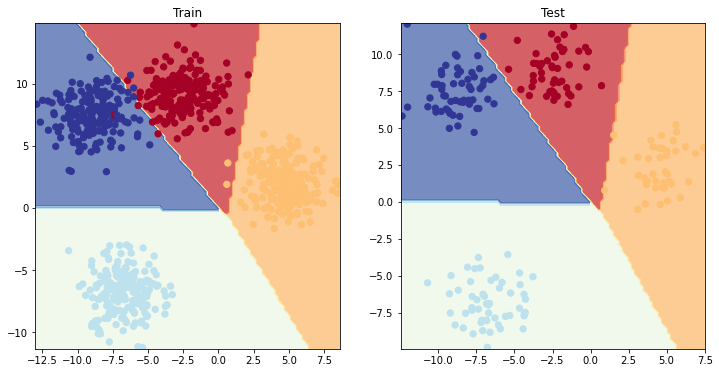

In [81]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# 6. More classification evaluation metrics

![eval_matrix](media/eval_mat.png)

In [82]:
!pip -q install torchmetrics

In [86]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  9.0456,  15.0193,  -8.9350,  -4.0027],
        [ -0.7123, -18.4017,  -2.2680,   4.8906],
        [-13.7129, -24.1734,  13.9078,   5.7032],
        [  4.8120,   9.9222,  -4.2728,  -2.8219],
        [ 10.0808,   5.7406, -12.0556,  -1.2943],
        [ -1.4195, -22.5796,  -2.1152,   6.0351],
        [-12.6774, -19.5705,  13.3991,   4.4586],
        [  7.0078,  -0.7074,  -9.1888,   0.3454],
        [-16.1919, -32.0740,  15.7126,   7.7945],
        [  7.9838,   1.6031, -10.0499,  -0.2502]])

In [87]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


In [89]:
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy().to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)